# Covid Research 20201130

***
## 0. Import

In [3]:
import GAN
from GAN import *

import gc
import hdbscan
import importlib
import math
import numpy as np
import operator
import pandas as pd
import psutil
from matplotlib import pyplot as plt

from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, OrdinalEncoder, LabelEncoder

gc.collect()
print(list(psutil.virtual_memory())[0:2])

Using TensorFlow backend.


[17179869184, 7673843712]


***
## 1. Read Data

In [4]:
data = pd.read_excel('ed_pred.xlsx')
data = data.reset_index()
print(data.shape)
print(data.columns)
data.head()

(7380, 41)
Index(['index', 'patno', 'Admitted', 'AdmittingDepartment', 'COVIDResult',
       'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp',
       'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit',
       'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c',
       'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc',
       'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
       'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose',
       'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein',
       'cmp_albumin', 'cmp_bilirubin'],
      dtype='object')


,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
index                       7380 non-null int64
patno                       7380 non-null int64
Admitted                    7380 non-null int64
AdmittingDepartment         3003 non-null object
COVIDResult                 7380 non-null object
Age                         7380 non-null int64
FirstRace                   7379 non-null object
Ethnicity                   7380 non-null object
Sex                         7380 non-null object
heart_rate                  7352 non-null float64
sbp                         7292 non-null float64
dbp                         7292 non-null float64
pulse_ox                    7346 non-null float64
resp_rate                   7312 non-null float64
height                      456 non-null float64
wght                        3248 non-null float64
cbc_wbc                     6256 non-null float64
cbc_hematocrit              6256 non-null float64
cbc_hem

In [6]:
data.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [7]:
data.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


In [8]:
label_cols = ['COVIDResult']
data_cols = list(data.columns[ data.columns != 'COVIDResult' ])

print(data_cols)
print('# of data columns: ',len(data_cols))

['index', 'patno', 'Admitted', 'AdmittingDepartment', 'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin']
# of data columns:  40


In [9]:
data.groupby('COVIDResult')['COVIDResult'].count()

COVIDResult
Detected          470
None Detected    6910
Name: COVIDResult, dtype: int64

In [10]:
data.isnull().sum().sum()

69411

In [11]:
normal_duplicates = sum( data.loc[ data.COVIDResult=='None Detected' ].duplicated() )
detected_duplicates = sum( data.loc[ data.COVIDResult=='Detected' ].duplicated() )
total_duplicates = normal_duplicates + detected_duplicates

print('Normal duplicates', normal_duplicates)
print('Detected duplicates', detected_duplicates)
print('Total duplicates', total_duplicates)
print('Fraction duplicated', total_duplicates / len(data))

Normal duplicates 0
Detected duplicates 0
Total duplicates 0
Fraction duplicated 0.0


***
## 2. Preprocess

### 2.1 Drop neutral columns

In [12]:
data_GAN = data.copy()
neutral_cols = ['index', 'patno', 'AdmittingDepartment', 'FirstRace', 'Ethnicity']
data_GAN = data_GAN.drop(neutral_cols, axis=1)
data_GAN.head()

,Admitted,COVIDResult,Age,Sex,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,1,None Detected,78,Female,94.0,138.0,82.0,96.0,29.0,NaN,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,0,None Detected,23,Female,121.0,134.0,88.0,98.0,18.0,NaN,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,0,None Detected,55,Male,83.0,152.0,76.0,98.0,21.0,NaN,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,1,None Detected,50,Male,88.0,138.0,65.0,87.0,18.0,NaN,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,0,None Detected,67,Female,90.0,128.0,69.0,98.0,18.0,NaN,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


### 2.2 Missing values

In [13]:
def numerical_imputer_preprocess(x_num):
    for i in range(len(x_num)):
        for j in range(len(x_num[i])):
            if isinstance(x_num[i][j], str):
                if (ord('0') <= ord(x_num[i][j][0]) <= ord('9')):
                    x_num[i][j] = float(x_num[i][j])
                else:
                    x_num[i][j] = float(x_num[i][j][1:])
                    
    imp = SimpleImputer(strategy='constant', fill_value=0)
    x_num = imp.fit_transform(x_num)
    
    return x_num

missing_cols = []
for i in range(len(data_GAN.isnull().values.transpose())):
    if True in list(data_GAN.isnull().values.transpose()[i]):
        missing_cols.append(data_GAN.columns[i])
        
data_GAN_missing = data_GAN[missing_cols]
data_GAN_missing = numerical_imputer_preprocess(data_GAN_missing.values)
data_GAN_without_missing = data_GAN.copy()
data_GAN_without_missing[missing_cols] = data_GAN_missing
data_GAN_without_missing.head()

,Admitted,COVIDResult,Age,Sex,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,1,None Detected,78,Female,94.0,138.0,82.0,96.0,29.0,0.0,...,26.0,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5
1,0,None Detected,23,Female,121.0,134.0,88.0,98.0,18.0,0.0,...,19.0,11.0,0.9,83.0,73.0,0.0,100.0,8.1,4.6,0.6
2,0,None Detected,55,Male,83.0,152.0,76.0,98.0,21.0,0.0,...,23.0,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7
3,1,None Detected,50,Male,88.0,138.0,65.0,87.0,18.0,0.0,...,30.0,45.0,1.6,297.0,22.0,0.0,78.0,7.8,3.7,0.5
4,0,None Detected,67,Female,90.0,128.0,69.0,98.0,18.0,0.0,...,27.0,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2


### 2.3 Encoder for categorial values

In [14]:
cat_cols = ['Sex']
data_GAN_cat = data_GAN[cat_cols]
data_GAN_cat = OrdinalEncoder().fit_transform(data_GAN_cat.values)
data_GAN_with_cat = data_GAN_without_missing.copy()
data_GAN_with_cat['Sex'] = data_GAN_cat
data_GAN_with_cat.head()

,Admitted,COVIDResult,Age,Sex,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,1,None Detected,78,0.0,94.0,138.0,82.0,96.0,29.0,0.0,...,26.0,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5
1,0,None Detected,23,0.0,121.0,134.0,88.0,98.0,18.0,0.0,...,19.0,11.0,0.9,83.0,73.0,0.0,100.0,8.1,4.6,0.6
2,0,None Detected,55,1.0,83.0,152.0,76.0,98.0,21.0,0.0,...,23.0,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7
3,1,None Detected,50,1.0,88.0,138.0,65.0,87.0,18.0,0.0,...,30.0,45.0,1.6,297.0,22.0,0.0,78.0,7.8,3.7,0.5
4,0,None Detected,67,0.0,90.0,128.0,69.0,98.0,18.0,0.0,...,27.0,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2


In [15]:
def y_preprocess(y):
    le = LabelEncoder()
    y = le.fit_transform(y)
    for i in range(len(y)):
        y[i] = 1 - y[i]
    
    return y

data_GAN_y = data_GAN[label_cols]
data_GAN_y = y_preprocess(data_GAN_y.values.ravel())
data_GAN_with_y = data_GAN_with_cat.copy()
data_GAN_with_y = data_GAN_with_y.drop(label_cols, axis=1)
data_GAN_with_y['COVIDResult'] = data_GAN_y
data_GAN_with_y.head()

,Admitted,Age,Sex,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult
0,1,78,0.0,94.0,138.0,82.0,96.0,29.0,0.0,0.0,...,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5,0
1,0,23,0.0,121.0,134.0,88.0,98.0,18.0,0.0,0.0,...,11.0,0.9,83.0,73.0,0.0,100.0,8.1,4.6,0.6,0
2,0,55,1.0,83.0,152.0,76.0,98.0,21.0,0.0,2963.0,...,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7,0
3,1,50,1.0,88.0,138.0,65.0,87.0,18.0,0.0,0.0,...,45.0,1.6,297.0,22.0,0.0,78.0,7.8,3.7,0.5,0
4,0,67,0.0,90.0,128.0,69.0,98.0,18.0,0.0,0.0,...,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2,0


### 2.4 Normalizer

In [16]:
num_cols = list(data_GAN_with_y.columns)
for i in cat_cols + label_cols + ['Admitted']:
    num_cols.remove(i)
    
data_GAN_num = data_GAN_with_y[num_cols]
norm = Normalizer()
data_GAN_num = norm.fit_transform(data_GAN_num.values)
data_GAN_scaled = data_GAN_with_y.copy()
data_GAN_scaled[num_cols] = data_GAN_num
data_GAN_scaled.head()

,Admitted,Age,Sex,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult
0,1,0.178983,0.0,0.215697,0.316662,0.188161,0.220287,0.066545,0.0,0.000000,...,0.071134,0.005737,0.188161,0.032125,0.059661,0.183572,0.019505,0.009867,0.001147,0
1,0,0.050992,0.0,0.268261,0.297083,0.195099,0.217270,0.039907,0.0,0.000000,...,0.024387,0.001995,0.184014,0.161844,0.000000,0.221704,0.017958,0.010198,0.001330,0
2,0,0.018390,1.0,0.027753,0.050824,0.025412,0.032768,0.007022,0.0,0.990736,...,0.003009,0.000401,0.041127,0.008694,0.009697,0.035443,0.002374,0.001337,0.000234,0
3,1,0.117092,1.0,0.206081,0.323173,0.152219,0.203739,0.042153,0.0,0.000000,...,0.105382,0.003747,0.695524,0.051520,0.000000,0.182663,0.018266,0.008665,0.001171,0
4,0,0.152791,0.0,0.205242,0.291900,0.157352,0.223486,0.041048,0.0,0.000000,...,0.057012,0.002280,0.218925,0.027366,0.041048,0.278217,0.016875,0.007982,0.000456,0


### 2.5 Data prepared

In [17]:
data_prepared = data_GAN_scaled.copy()
data_prepared.head()

,Admitted,Age,Sex,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult
0,1,0.178983,0.0,0.215697,0.316662,0.188161,0.220287,0.066545,0.0,0.000000,...,0.071134,0.005737,0.188161,0.032125,0.059661,0.183572,0.019505,0.009867,0.001147,0
1,0,0.050992,0.0,0.268261,0.297083,0.195099,0.217270,0.039907,0.0,0.000000,...,0.024387,0.001995,0.184014,0.161844,0.000000,0.221704,0.017958,0.010198,0.001330,0
2,0,0.018390,1.0,0.027753,0.050824,0.025412,0.032768,0.007022,0.0,0.990736,...,0.003009,0.000401,0.041127,0.008694,0.009697,0.035443,0.002374,0.001337,0.000234,0
3,1,0.117092,1.0,0.206081,0.323173,0.152219,0.203739,0.042153,0.0,0.000000,...,0.105382,0.003747,0.695524,0.051520,0.000000,0.182663,0.018266,0.008665,0.001171,0
4,0,0.152791,0.0,0.205242,0.291900,0.157352,0.223486,0.041048,0.0,0.000000,...,0.057012,0.002280,0.218925,0.027366,0.041048,0.278217,0.016875,0.007982,0.000456,0


***
## 3. XGBoost

### 3.1 Setup

In [18]:
test_cols = data_prepared.columns
print(len(test_cols))
print(test_cols)

36
Index(['Admitted', 'Age', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox',
       'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit',
       'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c',
       'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc',
       'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
       'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose',
       'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein',
       'cmp_albumin', 'cmp_bilirubin', 'COVIDResult'],
      dtype='object')


In [19]:
def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

np.random.seed(0)

n_real = np.sum(data_prepared.COVIDResult==0)
n_test = np.sum(data_prepared.COVIDResult==1)
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data_prepared.loc[data_prepared.COVIDResult==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data_prepared.loc[data_prepared.COVIDResult==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print('classes 0, 1: ', n_real, n_test)
print('train, test: ', len(train_df), len(test_df))

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

classes 0, 1:  6910 470
train, test:  5166 2214


### 3.2 Run algorithm

In [20]:
results_dict = {}

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
#                      feval = recall,
                     maximize=True,
)

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['COVIDResult'].values
print('best iteration: ', xgb_test.best_iteration)
print(recall(y_pred, dtest))
print(precision(y_pred, dtest))
print(roc_auc(y_pred, dtest))
SimpleMetrics(np.round(y_pred), y_true)

best iteration:  5
('recall', 0.0070921985815602835)
('precision', 0.5)
('roc_auc', 0.7115514227162472)
Confusion Matrix


,Pred 0,Pred 1
True 0,2072,1
True 1,140,1


Accuracy : 0.9363143631436315


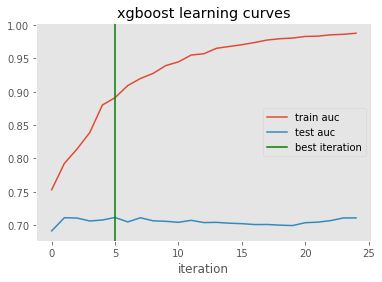

In [21]:
for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
plt.title('xgboost learning curves')
plt.legend()
plt.grid()

### 3.3 Feature importance

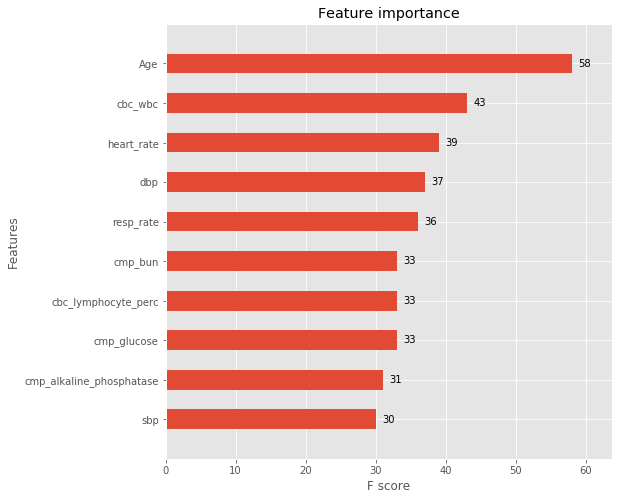

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);

In [23]:
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_cols = [i[0] for i in sorted_x] + ['COVIDResult']
print(sorted_cols)

['Age', 'cbc_wbc', 'heart_rate', 'dbp', 'resp_rate', 'cmp_glucose', 'cbc_lymphocyte_perc', 'cmp_bun', 'cmp_alkaline_phosphatase', 'cmp_bicarbonate', 'cmp_total_protein', 'cmp_bilirubin', 'sbp', 'cmp_alt', 'cbc_lymphocyte_c', 'cmp_potassium', 'cbc_hematocrit', 'cbc_eosinophil_c', 'cbc_monocyte_c', 'cmp_creatinine', 'cbc_neutrophil_c', 'pulse_ox', 'wght', 'cbc_platelets', 'cmp_albumin', 'cmp_chloride', 'cbc_hemoglobin', 'cmp_ast', 'cbc_eosinophil_perc', 'height', 'cmp_sodium', 'Sex', 'Admitted', 'COVIDResult']


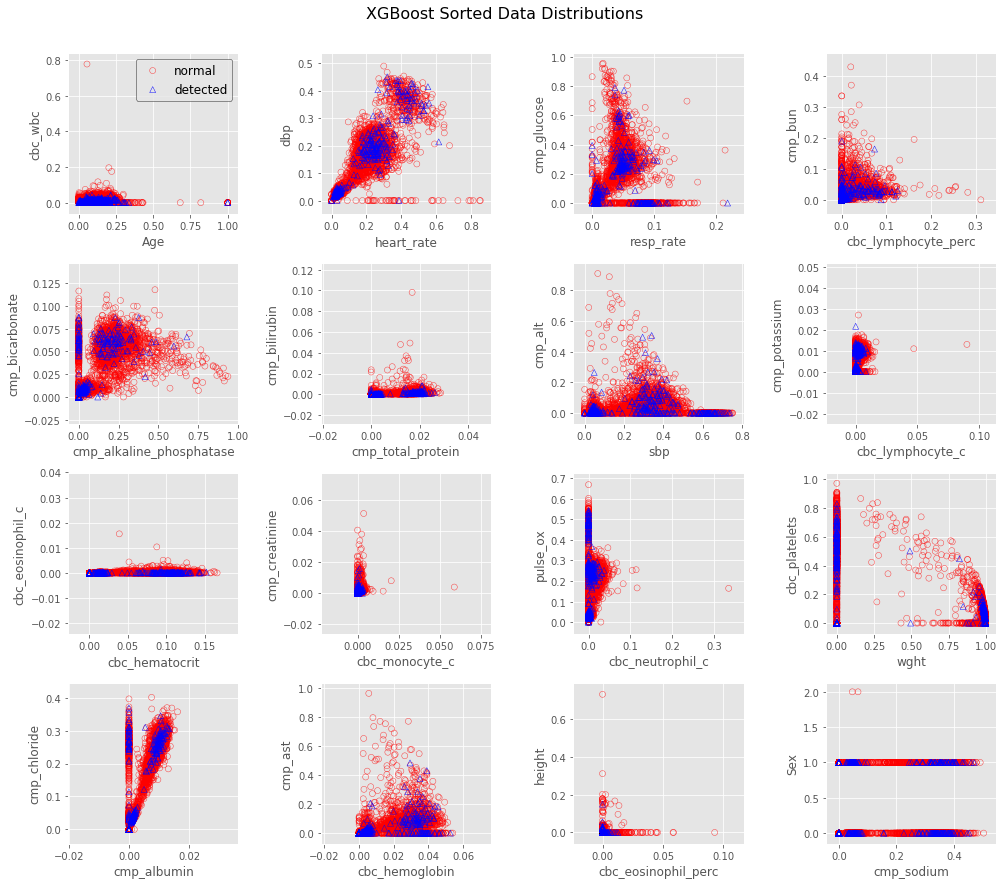

In [24]:
colors = ['red','blue']
markers = ['o','^']
labels = ['normal','detected']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('COVIDResult'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.show()

### 3.4 Ratio of normal:detected data

In [25]:
np.random.seed(0)

n_real = np.sum(data_prepared.COVIDResult==0)
n_test = np.sum(data_prepared.COVIDResult==1)
real_samples = data_prepared.loc[ data_prepared.COVIDResult==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data_prepared.loc[ data_prepared.COVIDResult==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = data_prepared.columns[:-1]
y_col = data_prepared.columns[-1]

test_data=[]

for i in np.logspace(-1,2,8):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5,
                     num_boost_round=100,
                     early_stopping_rounds=10,
                     seed=0,
#                      feval=recall,
    )
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1
0.2682695795279726
0.7196856730011519
1.9306977288832496
5.17947467923121
13.894954943731374
37.27593720314938
100.0


,ratio,best,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.100000,14,0.998578,0.000957,0.654727,0.041161
1,0.268270,7,0.991856,0.003912,0.689333,0.024169
2,0.719686,9,0.983942,0.003183,0.699333,0.024373
3,1.930698,21,0.995439,0.001415,0.738699,0.042614
4,5.179475,15,0.979792,0.005360,0.748921,0.023139
5,13.894955,14,0.967531,0.001475,0.750151,0.024099
6,37.275937,17,0.971302,0.002556,0.740162,0.025758
7,100.000000,17,0.971302,0.002556,0.740162,0.025758


***
## 4. Classification

### 4.1 Setup

In [26]:
train = data_prepared.loc[ data_prepared['COVIDResult']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['COVIDResult']==i)] for i in np.unique(train['COVIDResult']) ], columns=['count'], index=np.unique(train['COVIDResult']) ) )

label_cols = [ i for i in train.columns if 'COVIDResult' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

   count
1    470


### 4.2 Run algorithm

In [27]:
%%time
projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]

CPU times: user 19.8 s, sys: 462 ms, total: 20.2 s
Wall time: 6.26 s


0 KMeans
1 Agglomerative
2 HDBSCAN


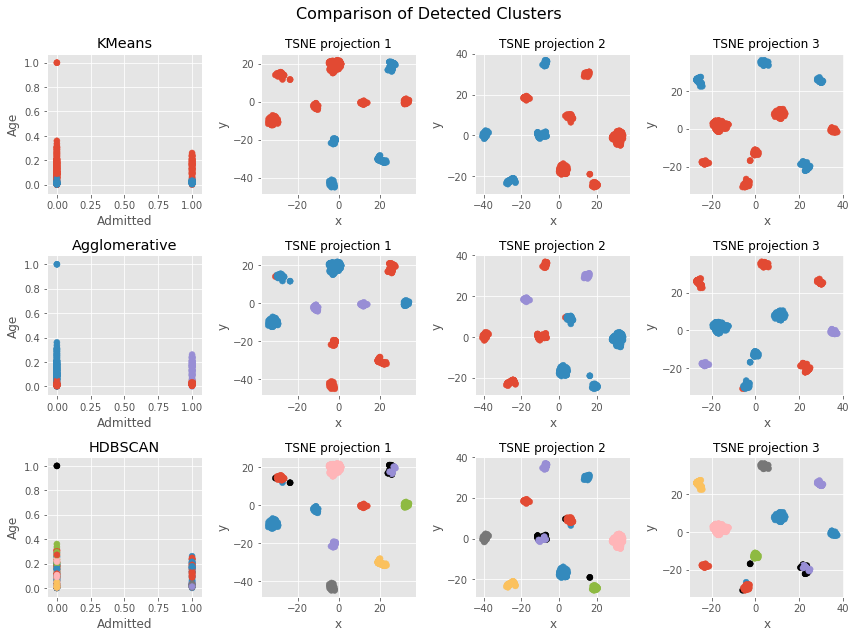

CPU times: user 3.51 s, sys: 303 ms, total: 3.82 s
Wall time: 2.2 s


In [28]:
%%time

algorithms = [ 
    [ 'KMeans', KMeans, (), {'n_clusters':2, 'random_state':0} ],
    [ 'Agglomerative', AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)

plt.suptitle('Comparison of Detected Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

### 4.3 Add some labels

In [29]:
algorithm = KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

detected_w_classes = train.copy()
detected_w_classes['COVIDResult'] = labels

   count
0    293
1    177


### 4.4 Feature importance

In [30]:
dtrain = xgb.DMatrix(detected_w_classes[data_cols], detected_w_classes['COVIDResult'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )

Top eight features:  [['wght', 10]]


***
## 5. Generative Adversarial Network

### 5.0 Reimport

In [31]:
importlib.reload(GAN) # For reloading after making changes
from GAN import *

### 5.1 Setup

In [32]:
rand_dim = 32 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

train = detected_w_classes.copy().reset_index(drop=True) # detected only with labels from classification

label_cols = [ i for i in train.columns if 'COVIDResult' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

### 5.2 Training the vanilla GAN and CGAN architectures

data_dim:  35
data_cols:  ['Admitted', 'Age', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin']
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_______________________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 0.6659, 0.7573, 0.6901, 1.0000
D Real - D Gen: -0.0673


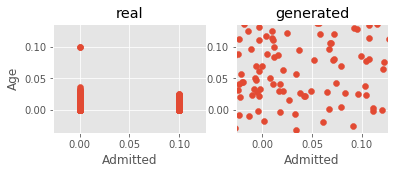

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8357, 0.6099, 0.6567, 0.9939
D Real - D Gen: 0.0468


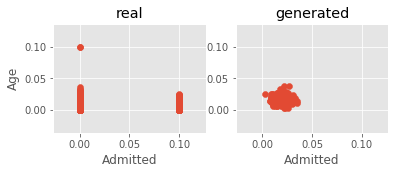

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.6266, 0.3366, 0.5791, 1.0000
D Real - D Gen: 0.2424


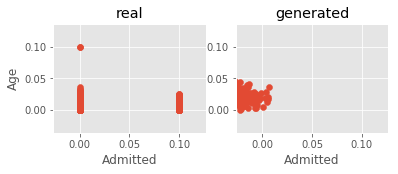

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.3047, 0.5433, 0.5932, 0.9837
D Real - D Gen: 0.0499


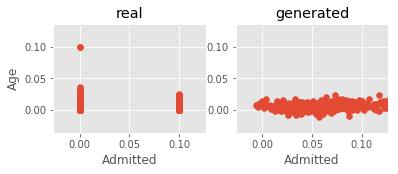

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0438, 0.7307, 0.6607, 0.9959
D Real - D Gen: -0.0700


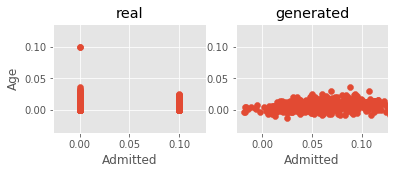

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2223, 0.5168, 0.5495, 0.9939
D Real - D Gen: 0.0327


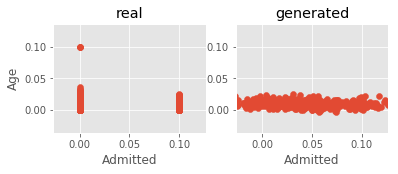

data_dim:  35
data_cols:  ['Admitted', 'Age', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin']
label_dim:  1
label_cols:  ['COVIDResult']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
_____________________________________________________________________________________

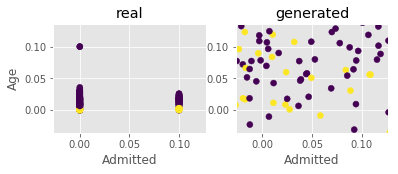

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.7321, 0.7087, 0.6640, 1.0000
D Real - D Gen: -0.0447


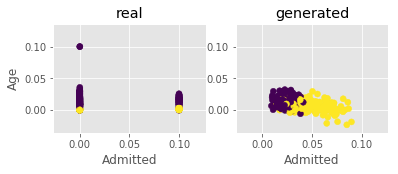

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8636, 0.6210, 0.6430, 1.0000
D Real - D Gen: 0.0221


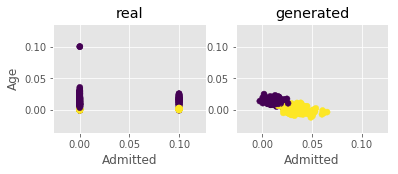

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9932, 0.6577, 0.6855, 1.0000
D Real - D Gen: 0.0278


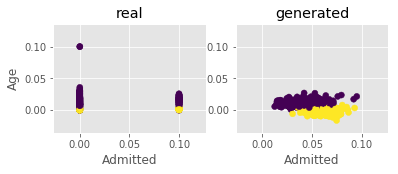

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0491, 0.5904, 0.6757, 0.9980
D Real - D Gen: 0.0853


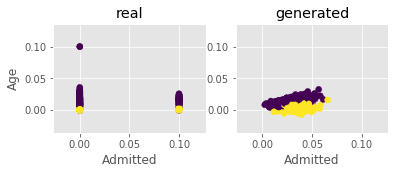

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0474, 0.5730, 0.7903, 0.9959
D Real - D Gen: 0.2173


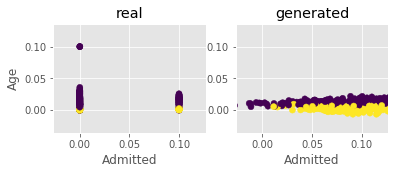

CPU times: user 1min 14s, sys: 6.75 s, total: 1min 21s
Wall time: 30.2 s


In [33]:
%%time

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

### 5.3 Training the WGAN and WCGAN architectures

data_dim:  35
data_cols:  ['Admitted', 'Age', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_18 (Dense)             

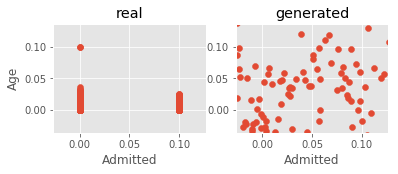

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0990, 0.1010, 0.1182, 0.9980
D Real - D Gen: 0.0172


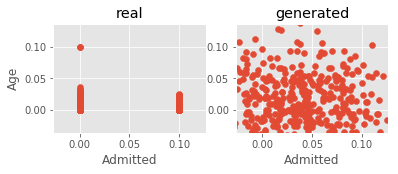

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: -0.1082, 0.1079, 0.1166, 1.0000
D Real - D Gen: 0.0087


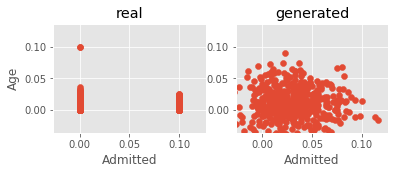

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: -0.1048, 0.1051, 0.1108, 1.0000
D Real - D Gen: 0.0057


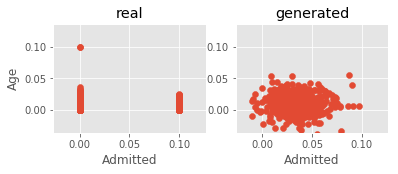

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0985, 0.0987, 0.1031, 0.9919
D Real - D Gen: 0.0044


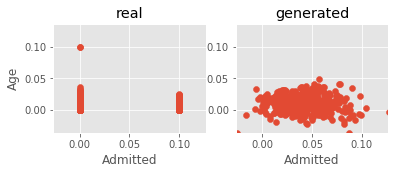

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0961, 0.0965, 0.1006, 1.0000
D Real - D Gen: 0.0041


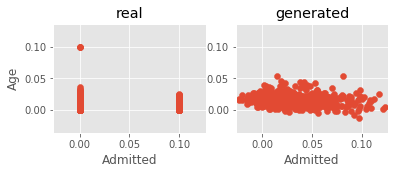

data_dim:  35
data_cols:  ['Admitted', 'Age', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin']
label_dim:  1
label_cols:  ['COVIDResult']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32)           0                                            
_____________________________________________________________________________________

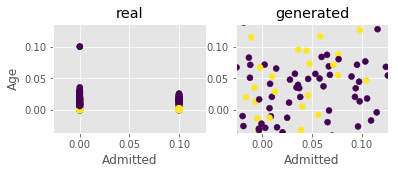

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0929, 0.0934, 0.1120, 1.0000
D Real - D Gen: 0.0186


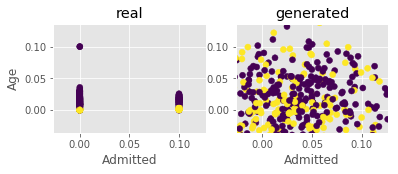

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: -0.1026, 0.1013, 0.1106, 0.9980
D Real - D Gen: 0.0093


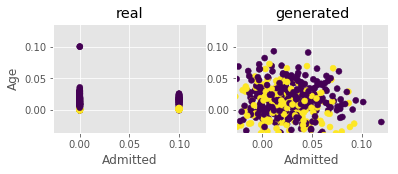

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: -0.1035, 0.1020, 0.1083, 1.0000
D Real - D Gen: 0.0062


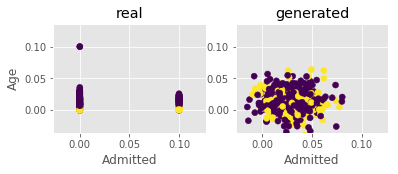

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: -0.1016, 0.1017, 0.1059, 0.9817
D Real - D Gen: 0.0042


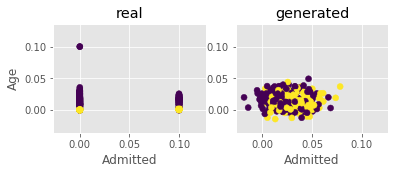

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0986, 0.0988, 0.1024, 0.9959
D Real - D Gen: 0.0036


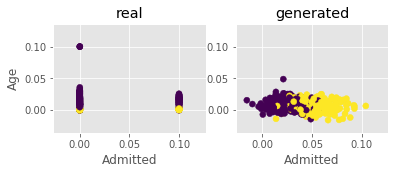

CPU times: user 3min 29s, sys: 16.5 s, total: 3min 46s
Wall time: 1min 36s


In [34]:
%%time

k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

### 5.4 Reload loss data from pickles

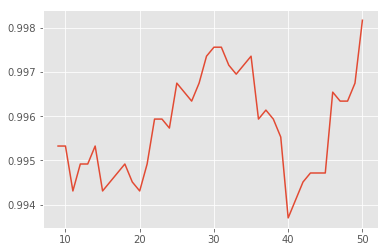

In [35]:
prefix = 'WCGAN'
step = 500

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))

w = 10
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;

### 5.5 Step with lowest xgboost accuracy and critic loss

In [36]:
best_step = list(xgb_losses).index( xgb_losses.min() ) * 10
print( best_step, xgb_losses.min() )

xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 10) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

360 0.9776422764227642
400 0.9817073170731707


In [37]:
delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

467 0.003257759
500 0.003580913


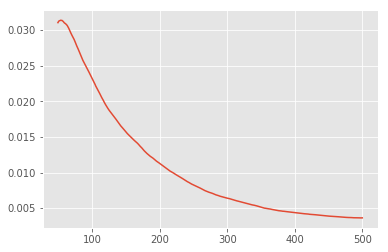

In [38]:
w = 50
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

***
## 6. Generated data

### 6.1 Setup

In [39]:
seed = 17

train = detected_w_classes.copy().reset_index(drop=True) # detected only with labels from classification

label_cols = [ i for i in train.columns if 'COVIDResult' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('cache/CGAN_generator_model_weights_step_500.h5')

### 6.2 Generate some new data

0.997872340425532


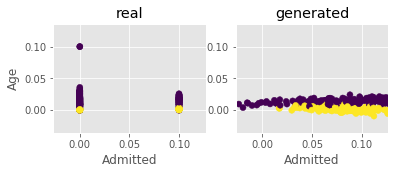

In [40]:
test_size = 470 # Equal to all of the detected cases

x = get_data_batch(train, test_size, seed=i+j)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)
    
print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )
PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

### 6.3 XGBoost classifier on generated data

In [41]:
def evaluation(y_test, y_pred):
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1 score: {:.2f}%".format(f1_score(y_test, y_pred) * 100))

real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
y_true = test_df['syn_label']

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))
evaluation(y_pred, y_true)
# print( '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) )
# SimpleMetrics(y_pred,y_true)

Confusion matrix:
[[235   1]
 [  0 234]]
Accuracy: 99.79%
Precision: 99.57%
Recall: 100.00%
F1 score: 99.79%


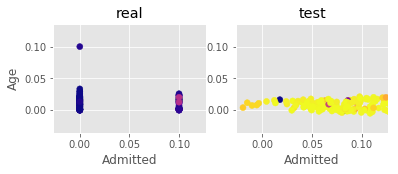

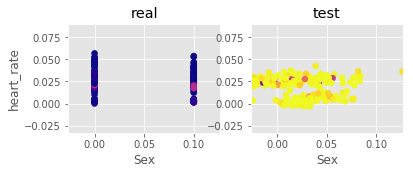

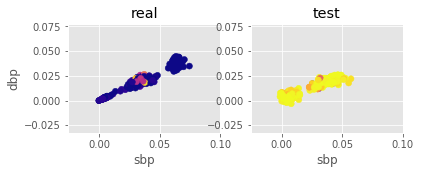

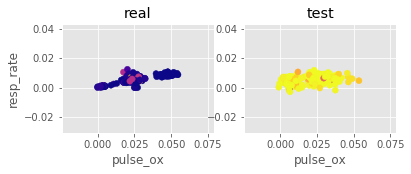

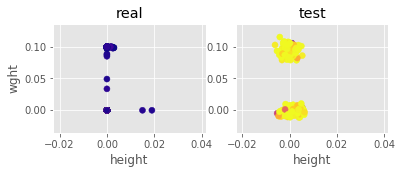

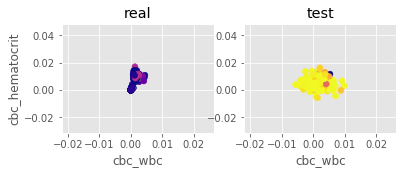

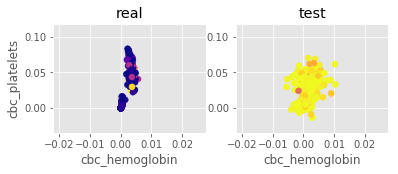

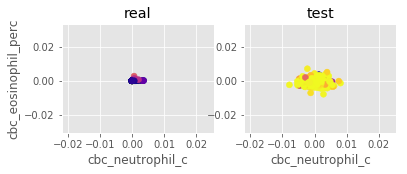

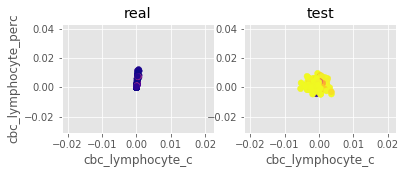

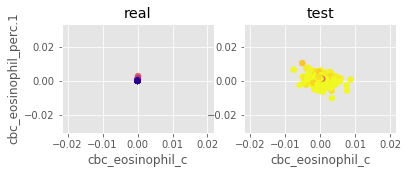

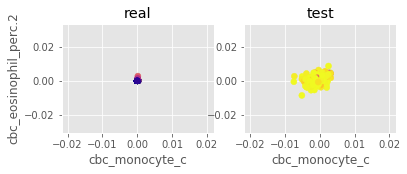

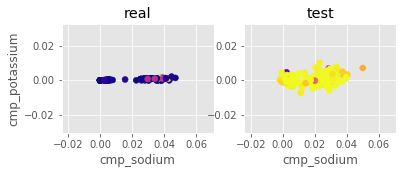

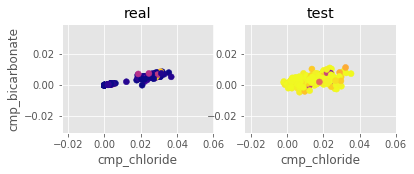

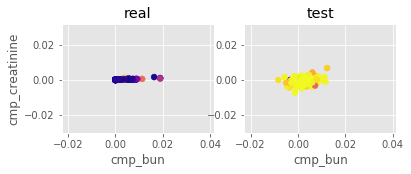

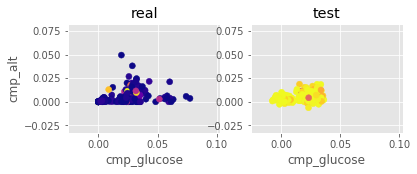

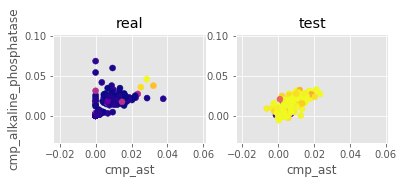

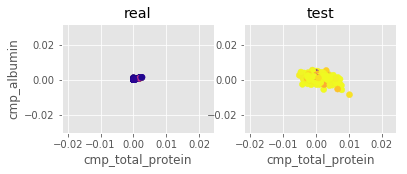

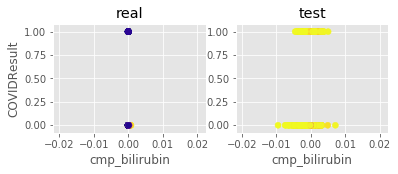

In [42]:
y_pred0 = xgb_test.predict(dtest)

for i in range(0,len(X_col)-1, 2):

    f, axarr = plt.subplots(1, 2, figsize=(6,2) )

    axarr[0].scatter( test_df[:n_real][X_col[i]], test_df[:n_real][X_col[i+1]], c=y_pred0[:n_real], cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[i+1])

    axarr[1].scatter( test_df[n_real:][X_col[i]], test_df[n_real:][X_col[i+1]], c=y_pred0[n_real:], cmap='plasma'  )
    axarr[1].set_title('test')
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())

    for a in axarr:
        a.set_xlabel(X_col[i])

    plt.show()

### 6.4 Compare real and generated data

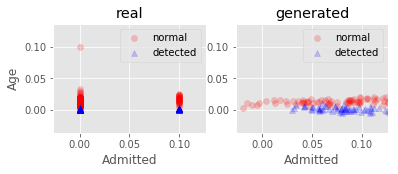

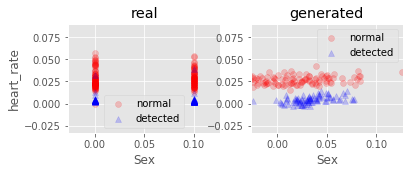

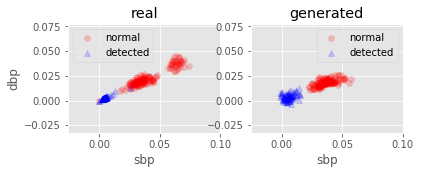

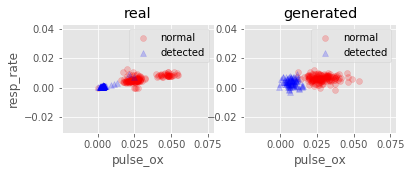

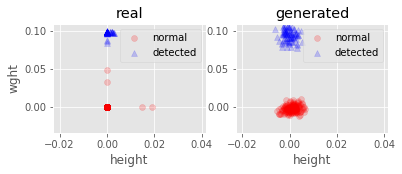

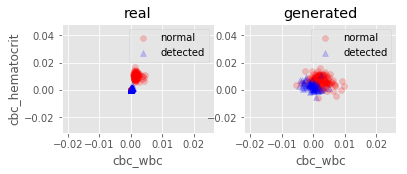

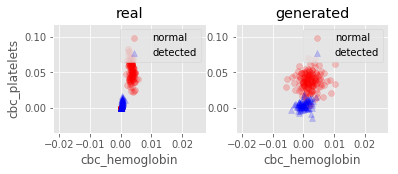

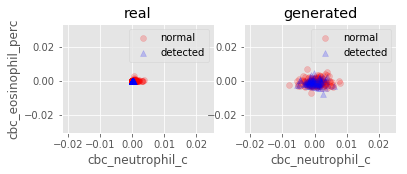

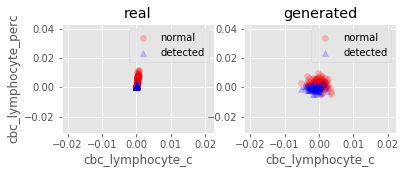

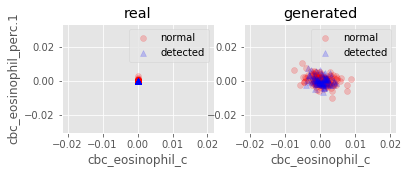

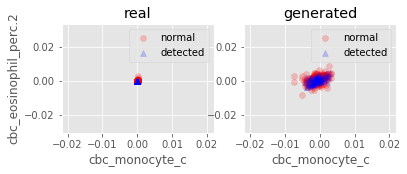

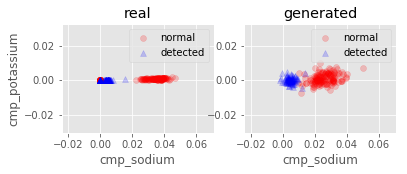

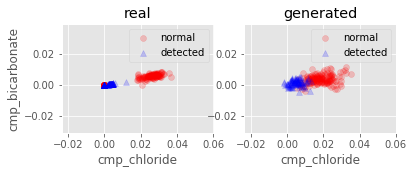

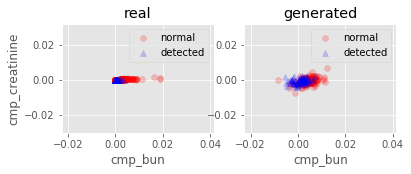

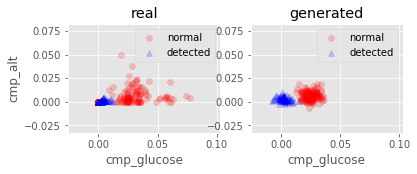

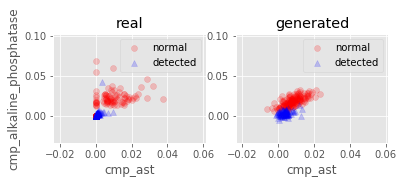

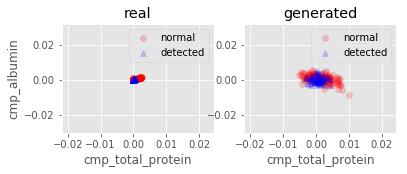

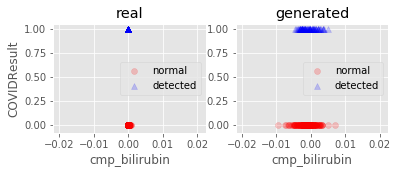

In [43]:
colors = ['red','blue']
markers = ['o','^']
labels = ['normal','detected']

class_label = 'COVIDResult'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') ;

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()

***
## 7. Feature importance

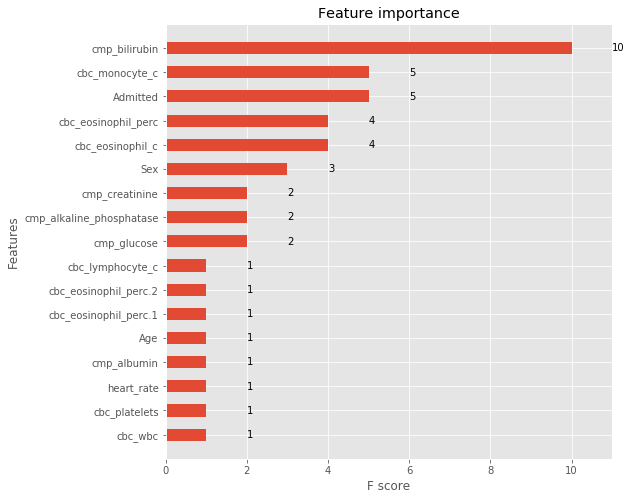

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

***
## 8. Logistic Regression

In [128]:
train, test = train_test_split(x, test_size=0.2)
x_train = train[:, 0:-1]
x_test = test[:, 0:-1]
y_train = train[:, -1]
y_test = test[:, -1]

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[60  0]
 [ 4 30]]
Accuracy: 95.74%
Precision: 100.00%
Recall: 88.24%
F1 score: 93.75%
